In [1]:
%matplotlib notebook
import control as c
import ipywidgets as w
import numpy as np

from IPython.display import display, HTML, Math
import matplotlib.pyplot as plt
import matplotlib.animation as animation

#display(HTML('<script> $(document).ready(function() { $("div.input").hide(); }); </script>'))

# Toggle cell visibility
from IPython.display import HTML
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.input').hide()
    } else {
        $('div.input').show()
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Promijeni vidljivost <a href="javascript:code_toggle()">ovdje</a>.''')
display(tag)

## Formulacija Bodeovog dijagrama

Kroz sljedeći primjer analizirat ćemo prijenosne karakteristike faze i amplitude linearnih vremenski nepromjenjivih (engl. Linear Time-Invariant; LTI) sustava u frekvencijskoj domeni. Ta se svojstva uobičajeno prikazuju parom grafova koji se nazivaju Bodeov dijagram. Amplituda se izražava u decibelima, faza u kutovima, a označavaju se u odnosu na kutnu frekvenciju ili kutnu frekvenciju (obično s logaritamskom skalom) sinusoidalnog ulaznog signala.

Analizom ovih grafova moguće je utvrditi neka dinamička svojstva sustava koje oni predstavljaju.

<br><b>Odaberite tip sustava!</b>

In [2]:
def print_model(model):
    
    print ('\nOdabrani model sustava:')

    if model == 0:
        display(Math(r'$$G(s)=\frac{s-Z}{s-P}$$'))
    elif model == 1:
        display(Math(r'$$G(s)=\frac{K_i(s-Z)}{s(s-P)}$$'))
    elif model == 2:
        display(Math(r'$$G(s)=\frac{K_d\cdot s}{(s-P)}$$'))
    elif model == 3:
        display(Math(r'$$G(s)=\frac{s-Z}{(s-P_1)(s-P_2)}$$'))
    else:
        display(Math(r'$$G(s)=\frac{s-Z}{s^2+2\zeta\omega_0s+{\omega_0}^2}$$'))
            

systemSelect = w.ToggleButtons(
    options=[('Sustav prvog reda', 0), ('Sustav prvog reda, integrirajući', 1), ('Sustav prvog reda, diferencijacijski', 2),
             ('Sustav drugog reda, prekomjerno prigušen', 3), ('Sustav drugog reda, nedovoljno prigušen', 4)],
    description='Sustav: ', layout=w.Layout(width='100%'))

systemSelect.style.button_width='48%'

input_data = w.interactive_output(print_model, {'model': systemSelect})

display(systemSelect, input_data)


ToggleButtons(description='Sustav: ', layout=Layout(width='100%'), options=(('Sustav prvog reda', 0), ('Sustav…

Output()

Bodeov dijagram se može aproksimirati asimptotskim linijama, koje je lako ručno izračunati koristeći sljedeća pravila:

<b>Graf amplitude:</b>
<ul>
    <li>
        Na svakom se polu nagib povećava, a na svakoj nuli smanjuje za 20dB. Učinci preklapanja polova i nula se kombiniraju.
    <li>
        Početni nagib određuje se brojem nula i polova koji nisu prikazani na dijagramu (na primjer, integrirajuće i diferencirajuće komponente), izračunato prema prethodnim pravilima. Bez polova ili nula izvan područja crtanja, nagib je vodoravan.
    </li>
    <li>
        Početna vrijednost određuje se supstitucijom početne točke u jednadžbi:
        <br>$M_{start}=|G(j\omega_{start})|$ where $j\omega=s$
    </li>
    <li>
        (Nestabilni) polovi i nule na desnoj strani ravnine rade suprotno svojim stabilnim pandanima. <i> Međutim, oni nisu zastupljeni u ovom primjeru.</i>
    </li>
</ul>
<br>
<b>Graf faze:</b>
<ul>
    <li>
        Ako je statička apmplituda (K) funkcije oblika $G(s)= \prod{K\frac{(b_i-Z_i)}{(a_i-P_i)}}$ pozitivna, tada je početna faza jednaka 0°, a inače -180°.
    </li>
    <li>
        Polovi i nule prije početne točke (na primjer, integrirajuće i diferencirajuće komponente) povećavaju (nule) ili smanjuju (polovi) početnu fazu za 90°.
    </li>
    <li>
        Polovi smanjuju, a nule povećavaju fazu za 90°, što se može prikazati nagibom od 45° oko njihove frekvencije (započinjući dekadu ranije i završavajući dekadu kasnije). Komponente koje se preklapaju kombiniraju svoje učinke.
    </li>
    <li>
        Slično grafu amplitude, (nestabilni) polovi i nule na desnoj strani ravnine rade suprotno svojim stabilnim pandanima. <i> Međutim, oni nisu zastupljeni u ovom primjeru. </i>
    </li>
</ul>

Polovi i nule s realnim vrijednostima predstavljeni su izravno na Bodeovom dijagramu sa svojim apsolutnim vrijednostima, ali za kompleksne parove treba izračunati $\omega_0$, kada su predstavljeni kao polovi drugog reda. Ako se os frekvencije Bodeovog dijagrama označava jedinicom Hz, sve vrijednosti moraju se podijeliti s $2\pi$!

Asimptotski graf može se dodatno poboljšati dodavanjem vrhova i zakrivljenosti, ali u ovom se primjeru držimo verzije s isključivo ravnim linijama.

<b>Odaberite parametre sustava i promatrajte promjene u Bodeovom dijagramu!</b>
<br><b>Na kojim položajima asimptotska aproksimacija dobro odgovara izvornim karakteristikama? Zašto?</b>

In [3]:
def calculate_tf(P1, P2, Z, Zb, model):
    
    if model == 0:
        if Zb:
            W = c.tf([1, Z], [1, P1])
        else:
            W = c.tf([1], [1, P1])
    elif model == 1:
        if Zb:
            W = c.tf([P2, P2*Z], [1, -P1, 0])
        else:
            W = c.tf([P2], [1, P1, 0])
    elif model == 2:
         W = c.tf([P2, 0], [1, P1])
    elif model == 3:
        if Zb:
            W = c.tf([1, Z], [1, P1+P2, P1*P2])
        else:
            W = c.tf([1], [1, P1+P2, P1*P2])
    else:
        if Zb:
            W = c.tf([1, Z], [1, 2*P1*P2, P1*P1])
        else:
            W = c.tf([1], [1, 2*P1*P2, P1*P1])

    print('\n Rezultirajuća prijenosna funkcija:')
    print(W)
    
    poles, zeros = c.pzmap(W, Plot=False)
    
    print('Nule modela:')
    print(zeros)
    print('Polovi modela:')
    print(poles)

def draw_controllers(model):
    
    global P1_slider, P2_slider, Z_slider, Z_button

    if model == 0:
        P1_slider = w.FloatLogSlider(value=0.5, base=10, min=-3, max=3, description='Pol', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'), disabled=False)
        P2_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description='', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'), disabled=True)
        Z_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description='Nula', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'), disabled=False)
        Z_button = w.ToggleButton(value=True, description='Dodaj/ukloni nulu',
                               layout=w.Layout(width='auto'), disabled=False)

    elif model == 1:
        P1_slider = w.FloatLogSlider(value=0.5, base=10, min=-3, max=3, description='Pol', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'), disabled=False)
        P2_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description='Ki', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'), disabled=False)
        Z_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description='Nula', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'), disabled=False)
        Z_button = w.ToggleButton(value=True, description='Dodaj/ukloni nulu',
                               layout=w.Layout(width='auto'), disabled=False)

        
    elif model == 2:
        P1_slider = w.FloatLogSlider(value=0.5, base=10, min=-3, max=3, description='Pol', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'), disabled=False)
        P2_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description='Kd', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'), disabled=False)
        Z_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description='Nula', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'), disabled=True)
        Z_button = w.ToggleButton(value=True, description='Dodaj/ukloni nulu',
                               layout=w.Layout(width='auto'), disabled=True)
        
    elif model == 3:
        P1_slider = w.FloatLogSlider(value=0.5, base=10, min=-3, max=3, description='Pol 1', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'), disabled=False)
        P2_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description='Pol 2', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'), disabled=False)
        Z_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description='Nula', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'), disabled=False)
        Z_button = w.ToggleButton(value=True, description='Dodaj/ukloni nulu',
                               layout=w.Layout(width='auto'), disabled=False)
        
    else:
        P1_slider = w.FloatLogSlider(value=0.5, base=10, min=-3, max=3, description=r'$\omega_0$', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'), disabled=False)
        P2_slider = w.FloatLogSlider(value=1, base=10, min=-4, max=1, description=r'$\zeta$', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'), disabled=False)
        Z_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description='Nula', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'), disabled=False)
        Z_button = w.ToggleButton(value=True, description='Dodaj/ukloni nulu',
                               layout=w.Layout(width='auto'), disabled=False)
        
    
    input_data2 = w.interactive_output(calculate_tf, {'P1': P1_slider, 'P2': P2_slider, 'Z': Z_slider,
                                                      'Zb': Z_button, 'model': systemSelect})
    
    display(w.HBox([P1_slider, P2_slider, Z_button, Z_slider]), input_data2)
    
    
w.interactive_output(draw_controllers, {'model': systemSelect})

Output()

<IPython.core.display.Javascript object>


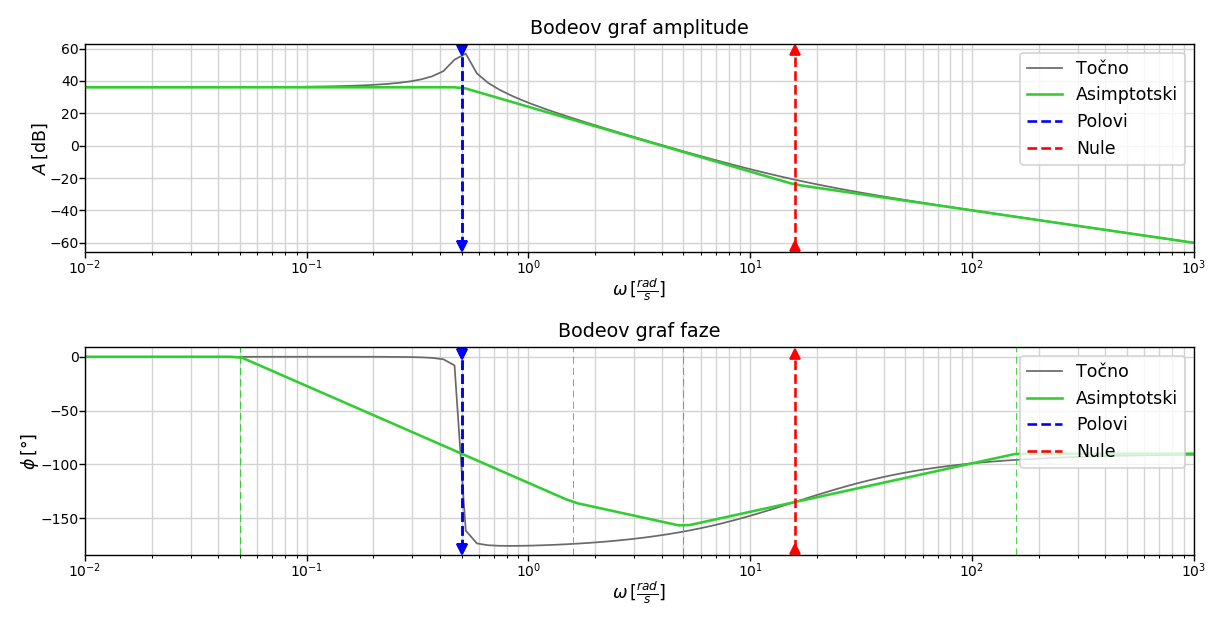

Output()

In [4]:
# Figure definition

fig1, ((f1_ax1), (f1_ax2)) = plt.subplots(2, 1)
fig1.set_size_inches((9.8, 5))
fig1.set_tight_layout(True)

f1_line1, = f1_ax1.plot([], [], lw=1, color='dimgrey')
f1_line3, = f1_ax1.plot([], [], lw=1, color='dimgrey')
f1_line2, = f1_ax2.plot([], [], lw=1.5, color='limegreen')
f1_line4, = f1_ax2.plot([], [], lw=1.5, color='limegreen')

f1_line5, = f1_ax1.plot([], [], color='blue', ls='--')
f1_line6, = f1_ax1.plot([], [], color='blue', ls='--')
f1_line7, = f1_ax1.plot([], [], color='red', ls='--')

f1_line8, = f1_ax2.plot([], [], color='blue', ls='--')
f1_line9, = f1_ax2.plot([], [], color='blue', ls='--')
f1_line10, = f1_ax2.plot([], [], color='red', ls='--')

f1_line11, = f1_ax2.plot([], [])
f1_line12, = f1_ax2.plot([], [])
f1_line13, = f1_ax2.plot([], [])
f1_line14, = f1_ax2.plot([], [])
f1_line15, = f1_ax2.plot([], [])
f1_line16, = f1_ax2.plot([], [])


f1_ax1.grid(which='both', axis='both', color='lightgray')
f1_ax2.grid(which='both', axis='both', color='lightgray')

f1_ax1.autoscale(enable=True, axis='x', tight=True)
f1_ax2.autoscale(enable=True, axis='x', tight=True)
f1_ax1.autoscale(enable=True, axis='y', tight=False)
f1_ax2.autoscale(enable=True, axis='y', tight=False)

f1_ax1.set_title('Bodeov graf amplitude', fontsize=11)
f1_ax1.set_xscale('log')
f1_ax1.set_xlabel(r'$\omega\/[\frac{rad}{s}]$', labelpad=0, fontsize=10)
f1_ax1.set_ylabel(r'$A\/$[dB]', labelpad=0, fontsize=10)
f1_ax1.tick_params(axis='both', which='both', pad=0, labelsize=8)

f1_ax2.set_title('Bodeov graf faze', fontsize=11)
f1_ax2.set_xscale('log')
f1_ax2.set_xlabel(r'$\omega\/[\frac{rad}{s}]$', labelpad=0, fontsize=10)
f1_ax2.set_ylabel(r'$\phi\/$[°]', labelpad=0, fontsize=10)
f1_ax2.tick_params(axis='both', which='both', pad=0, labelsize=8)

f1_ax1.legend([f1_line1, f1_line2, f1_line5, f1_line7], ['Točno', 'Asimptotski', 'Polovi', 'Nule'], loc='upper right')
f1_ax2.legend([f1_line3, f1_line4, f1_line8, f1_line10], ['Točno', 'Asimptotski', 'Polovi', 'Nule'], loc='upper right')

# System model

def draw_bode(P1, P2, Z, Zb, model):

    if model == 0:
        if Zb:
            W = c.tf([1, Z], [1, P1])
        else:
            W = c.tf([1], [1, P1])
    elif model == 1:
        if Zb:
            W = c.tf([P2, P2*Z], [1, P1, 0])
        else:
            W = c.tf([P2], [1, P1, 0])
    elif model == 2:
         W = c.tf([P2, 0], [1, P1])
    elif model == 3:
        if Zb:
            W = c.tf([1, Z], [1, P1+P2, P1*P2])
        else:
            W = c.tf([1], [1, P1+P2, P1*P2])
    else:
        if Zb:
            W = c.tf([1, Z], [1, 2*P1*P2, P1*P1])
        else:
            W = c.tf([1], [1, 2*P1*P2, P1*P1])            
    
    _, _, ob = c.bode_plot(W, Plot=False)   # Small resolution plot to determine bounds
    
    mag, phase, omega = c.bode_plot(W, omega=np.logspace(np.log10(ob[0]), np.log10(ob[-1]), 100), Plot=False)   # Bode-plot         
    poles, zeros = c.pzmap(W, Plot=False) # Poles and zeros
    
    log_omega = np.log10(omega)    
    
    mag_approx = np.full_like(mag, 20 * np.log10(mag[0]))
    phase_approx = np.full_like(phase, phase[0]*180/np.pi)
    
    pole_x = []
    zero_x = []
    break_x = []
    
    for p in poles:
        if p.imag == 0:
            om = abs(p.real)
        else:
            om = np.sqrt(p.real*p.real + p.imag*p.imag)
            
        if om == 0:
            mag_approx = mag_approx - 20 * (log_omega - np.log10(omega[0]))
            phase_approx = phase_approx - 90
        else:
            mag_approx = mag_approx - 20 * np.maximum(log_omega - np.log10(om), 0)
            phase_approx = phase_approx + 45 * np.maximum(log_omega - np.log10(om) - 1, 0)
            phase_approx = phase_approx - 45 * np.maximum(log_omega - np.log10(om) + 1, 0)
            
            pole_x.append(om)
            break_x.append(om/10)
            break_x.append(om*10)
            
    for z in zeros:
        if z.imag == 0:
            om = abs(z.real)
        else:
            om = np.sqrt(z.real*z.real + z.imag*z.imag)
            
        if om == 0:
            mag_approx = mag_approx + 20 * (log_omega - np.log10(omega[0]))
            phase_approx = phase_approx + 90
        else:
            mag_approx = mag_approx + 20 * np.maximum(log_omega - np.log10(om), 0)
            phase_approx = phase_approx - 45 * np.maximum(log_omega - np.log10(om) - 1, 0)
            phase_approx = phase_approx + 45 * np.maximum(log_omega - np.log10(om) + 1, 0)
            
            zero_x.append(om)
            break_x.append(om/10)
            break_x.append(om*10)
            
    global f1_line1, f1_line2, f1_line3, f1_line4
    global f1_line5, f1_line6, f1_line7, f1_line8, f1_line9, f1_line10
    global f1_line11, f1_line12, f1_line13, f1_line14, f1_line15, f1_line16
    
    f1_ax1.lines.remove(f1_line1)
    f1_ax1.lines.remove(f1_line3)
    f1_ax2.lines.remove(f1_line2)
    f1_ax2.lines.remove(f1_line4)

    f1_line1, = f1_ax1.plot(omega, 20*np.log10(mag), lw=1, color='dimgrey')
    f1_line3, = f1_ax1.plot(omega, mag_approx, lw=1.5, color='limegreen')
    f1_line2, = f1_ax2.plot(omega, phase*180/np.pi, lw=1, color='dimgrey')   
    f1_line4, = f1_ax2.plot(omega, phase_approx, lw=1.5, color='limegreen')
    
    f1_ax1.lines.remove(f1_line5)
    f1_ax1.lines.remove(f1_line6)
    f1_ax1.lines.remove(f1_line7)
    f1_ax2.lines.remove(f1_line8)
    f1_ax2.lines.remove(f1_line9)
    f1_ax2.lines.remove(f1_line10)
    
    if len(pole_x) >= 1:
        f1_line5 = f1_ax1.axvline(pole_x[0], color='blue', ls='--', ymin=0.03, ymax=0.97, marker='v')
        f1_line8 = f1_ax2.axvline(pole_x[0], color='blue', ls='--', ymin=0.03, ymax=0.97, marker='v')
    else:
        f1_line5, = f1_ax1.plot([], [])
        f1_line8, = f1_ax2.plot([], [])
    if len(pole_x) == 2:
        f1_line6 = f1_ax1.axvline(pole_x[1], color='blue', ls='--', ymin=0.03, ymax=0.97, marker='v')
        f1_line9 = f1_ax2.axvline(pole_x[1], color='blue', ls='--', ymin=0.03, ymax=0.97, marker='v')
    else:
        f1_line6, = f1_ax1.plot([], [])
        f1_line9, = f1_ax2.plot([], [])
    if len(zero_x) == 1:
        f1_line7 = f1_ax1.axvline(zero_x[0], color='red', ls='--', ymin=0.03, ymax=0.97, marker='^')
        f1_line10 = f1_ax2.axvline(zero_x[0], color='red', ls='--', ymin=0.03, ymax=0.97, marker='^')
    else:
        f1_line7, = f1_ax1.plot([], [])
        f1_line10, = f1_ax2.plot([], [])
        
    f1_ax2.lines.remove(f1_line11)
    f1_ax2.lines.remove(f1_line12)
    f1_ax2.lines.remove(f1_line13)
    f1_ax2.lines.remove(f1_line14)
    f1_ax2.lines.remove(f1_line15)
    f1_ax2.lines.remove(f1_line16)
        
    if len(break_x) >= 1:
        f1_line11 = f1_ax2.axvline(break_x[0], color='limegreen', lw=0.5, ls=(0, (8, 5)))
        f1_line12 = f1_ax2.axvline(break_x[1], color='limegreen', lw=0.5, ls=(0, (8, 5)))
    else:
        f1_line11, = f1_ax2.plot([], [])
        f1_line12, = f1_ax2.plot([], [])
        
    if len(break_x) >= 3:
        f1_line13 = f1_ax2.axvline(break_x[2], color='limegreen', lw=0.5, ls=(0, (8, 5)))
        f1_line14 = f1_ax2.axvline(break_x[3], color='limegreen', lw=0.5, ls=(0, (8, 5)))
    else:
        f1_line13, = f1_ax2.plot([], [])
        f1_line14, = f1_ax2.plot([], [])
           
    if len(break_x) >= 5:
        f1_line15 = f1_ax2.axvline(break_x[4], color='limegreen', lw=0.5, ls=(0, (8, 5)))
        f1_line16 = f1_ax2.axvline(break_x[5], color='limegreen', lw=0.5, ls=(0, (8, 5)))
    else:
        f1_line15, = f1_ax2.plot([], [])
        f1_line16, = f1_ax2.plot([], [])

    f1_ax1.relim()
    f1_ax2.relim()
    f1_ax1.autoscale_view()
    f1_ax2.autoscale_view()
    

def link_controls(model):
    w.interactive_output(draw_bode, {'P1': P1_slider, 'P2': P2_slider, 'Z': Z_slider,
                                     'Zb': Z_button, 'model': systemSelect})
    
w.interactive_output(link_controls, {'model': systemSelect})